In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group

In [2]:
#Setting
m = 20
m_1 = 1

In [3]:
def uniformSphere(d, m_x):
    x = np.random.normal(size=(m_x,d))
    for i in range(m_x):
        x[i] = x[i] / np.linalg.norm(x[i])
    return x
def test(a,x,f):
    return f(np.dot(a,x))

def g(x):
    return 1/(1+np.exp(-x))

def dg(x):
    #return sig(x)*(1-sig(x))
    return np.exp(x)/(1+np.exp(x))**2

def ddg(x):
    return -np.exp(x)*(np.exp(x) - 1)/(1+np.exp(x))**3

def dddg(x):
    return np.exp(x)(1-4*np.exp(x)+np.exp(2*x))/(1+np.exp(x))**4

def f_inner(x,a,foo):
    v = [foo(np.dot(x,e)) for e in a]
    return np.array(v)

def f(x,a,b):
    return g(np.dot(b[0],f_inner(x,a,g)))

def df(X,a,b):
    ret = []
    for x in X: 
        right = np.dot(A, b[0]*f_inner(x,a,dg))
        ret.append(dg(np.dot(b[:,0],f_inner(x,a,g)))*right)
    return ret

def ddf(X,a,b):
    ret = []
    samples = len(X)
    step = 0
    for x in X:
        
        if step % 1000 == 0:
            print("ddf: {0}/{1}".format(step, samples))
        step = step +1
        right = np.dot(A, b[0]*f_inner(x,a,dg))
        right2 = np.tensordot(right,right,axes=0)
        term1 = ddg(np.dot(b[:,0], f_inner(x,a,g)))*right2
        term2 = dg(np.dot(b[:,0],f_inner(x,a,g)))
        temp = np.zeros(shape = (m,m))
        for i in range(m):
            temp += b[i,0]*ddg(np.dot(a[:,i],x))*np.tensordot(a[:,i],a[:,i],axes=0)
        r = term1 + term2*temp
        ret.append(r)
    return ret

In [4]:
X = uniformSphere(m, 400)
A = ortho_group.rvs(dim = m)# m orthogonal vectors with dim m, a_1, ..., a_m
A = np.transpose(A)
B = ortho_group.rvs(dim = m)[:m_1]#m_1 orthogonal vectors with dimension m b_1, ..., b_m_1
B = np.transpose(B)

In [5]:
np.dot(A[:,0],X[0])

-0.12520237102649556

In [6]:
hmm = ddf(X, A,B)

ddf: 0/400


In [7]:
mak = [np.reshape(dd, (m**2,)) for dd in hmm]

In [8]:
M = np.transpose(np.array(mak))
M.shape

(400, 400)

In [9]:
U,D,V = np.linalg.svd(M)

In [10]:
V.shape

(400, 400)

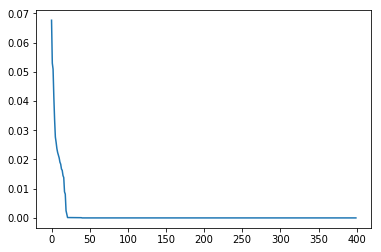

In [11]:
plt.plot(list(range(m**2)), D)

In [12]:
U_trunc = U[:,:2*m]
U_unvec = []
for i in range(2*m):
    U_unvec.append(np.reshape(U_trunc[:,i] , (m,m)))

In [13]:
for i in range(m):
    dist =[]
    for j in range(m+m_1):
        t = np.tensordot(A[:,i], A[:,i], axes=0) - U_unvec[j]
        t2 = -np.tensordot(A[:,i], A[:,i], axes=0) - U_unvec[j]
        d2 = np.linalg.norm(t2)
        d = np.linalg.norm(t)
        
        dist.append(np.min([d,d2]))
    print(dist, "\n")

[1.4020666654997143, 1.3928406188122853, 1.4005269561097413, 1.4010846745709571, 1.3990309132663354, 1.3593342296567248, 1.3779468699344715, 1.376676754174939, 1.004330449389482, 1.158798704903881, 0.93446508252257177, 1.1070660155173404, 1.1154432474246023, 1.3243206503218052, 1.386291419370818, 1.3653694299263737, 1.3899886209959103, 1.402116157116619, 1.413110490472739, 1.4141878495997071, 1.411191171626542] 

[1.4141440671400709, 1.4102520115920352, 1.4026662788859223, 1.4140142356758205, 1.404118827641663, 1.4116598673731975, 1.3947419086925033, 1.4053453021578182, 1.3501456520146438, 1.3886897144169463, 1.401802613952263, 1.3862845248257318, 1.4124583557973551, 1.3648695768862067, 1.4001227497630313, 1.4052126110962568, 1.4046256522376683, 0.46514969352707736, 1.0667914713910611, 1.3906341289147517, 1.4135241585856197] 

[1.4057968384221908, 1.4119139116709982, 1.397059859206758, 1.4128249259712744, 1.4048960888090078, 1.4005115338372656, 1.3462294715660572, 1.3771423295565335, 1

In [14]:
np.min(2,1)

AxisError: axis 1 is out of bounds for array of dimension 0

In [ ]:
U_unvec[0].shape